
# Прочитайте загруженный файл и нарисуйте последовательность



Просмотрите файлы и выберите путь

In [1]:
import os, glob
files_here = glob.glob("/content/*")
files_here

FILE_PATH = "/content/skab_valve_1 (1).csv"
assert os.path.isfile(FILE_PATH), f"File not found: {FILE_PATH}"
os.path.basename(FILE_PATH)


'skab_valve_1 (1).csv'

Чтение данных и подготовка времени

In [3]:
import pandas as pd
import numpy as np
import os

FILE_PATH = "/content/skab_valve_1 (1).csv"

df = pd.read_csv(FILE_PATH, sep=";", encoding="utf-8", engine="python")

df.columns = [c.strip() for c in df.columns]

required_cols = {"datetime", "Thermocouple", "anomaly"}
missing = required_cols - set(df.columns)
assert not missing, f"Missing required columns: {missing}. Available: {list(df.columns)}"

df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce")
df = df.dropna(subset=["datetime"]).sort_values("datetime").reset_index(drop=True)

df["anomaly"] = pd.to_numeric(df["anomaly"], errors="coerce").fillna(0).astype(int)

df.head()


,datetime,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
0,2020-03-09 12:34:37,0.028030,0.040400,1.18285,0.054711,69.9219,24.9122,229.918,32.9875,0,0.0
1,2020-03-09 12:34:38,0.026952,0.038880,1.45268,-0.273216,69.9147,24.9038,219.566,32.0129,0,0.0
2,2020-03-09 12:34:39,0.027958,0.040660,1.02300,0.054711,69.8861,24.9055,237.717,32.9875,0,0.0
3,2020-03-09 12:34:40,0.027277,0.040736,1.22751,-0.273216,69.8397,24.9110,227.621,32.0000,0,0.0
4,2020-03-09 12:34:41,0.027210,0.039489,1.21526,-0.273216,69.9136,24.9110,221.634,32.0129,0,0.0


Рисунок с обозначением нечетных точек

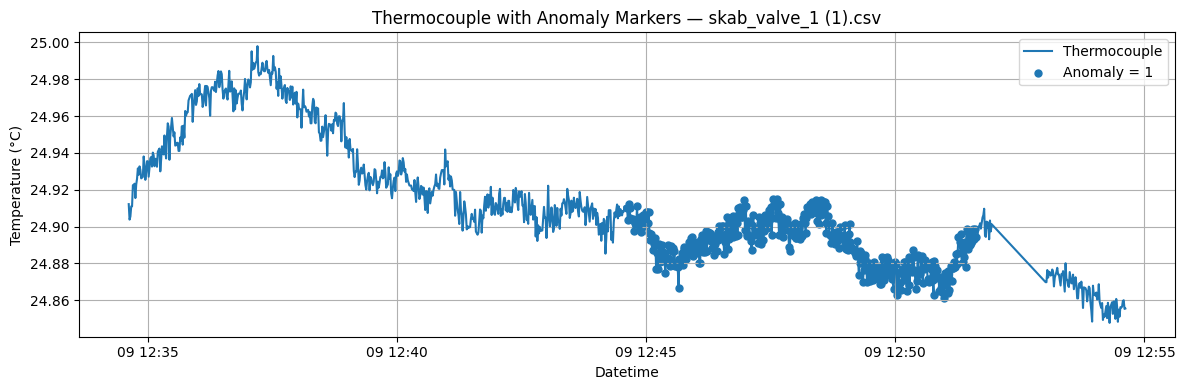

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(df["datetime"], df["Thermocouple"], label="Thermocouple")

anom = df[df["anomaly"] == 1]
if not anom.empty:
    ax.scatter(anom["datetime"], anom["Thermocouple"], s=25, label="Anomaly = 1")

ax.set_title(f"Thermocouple with Anomaly Markers — {os.path.basename(FILE_PATH)}")
ax.set_xlabel("Datetime")
ax.set_ylabel("Temperature (°C)")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


# Статистика (межквартильный размах) + Маркировка выбросов + Построение графиков + Матрица путаницы

Рассчитайте пороговые значения межквартильного интервала (1,5x и 3x)

In [5]:
s = df["Thermocouple"].astype(float)

Q1 = s.quantile(0.25)
Q3 = s.quantile(0.75)
IQR = Q3 - Q1

low_15, high_15 = Q1 - 1.5*IQR, Q3 + 1.5*IQR
low_3,  high_3  = Q1 - 3.0*IQR, Q3 + 3.0*IQR

print("Q1 =", Q1, "Q3 =", Q3, "IQR =", IQR)
print("IQR 1.5 bounds:", (low_15, high_15))
print("IQR 3.0 bounds:", (low_3, high_3))


Q1 = 24.88845 Q3 = 24.929275 IQR = 0.040825000000001666
IQR 1.5 bounds: (np.float64(24.827212499999995), np.float64(24.9905125))
IQR 3.0 bounds: (np.float64(24.765974999999994), np.float64(25.051750000000006))


Создание столбцов прогнозирования аномалий на основе пороговых значений

In [6]:
df["pred_iqr15"] = ((df["Thermocouple"] < low_15) | (df["Thermocouple"] > high_15)).astype(int)
df["pred_iqr3"]  = ((df["Thermocouple"] < low_3)  | (df["Thermocouple"] > high_3)).astype(int)

df[["datetime","Thermocouple","anomaly","pred_iqr15","pred_iqr3"]].head()


,datetime,Thermocouple,anomaly,pred_iqr15,pred_iqr3
0,2020-03-09 12:34:37,24.9122,0,0,0
1,2020-03-09 12:34:38,24.9038,0,0,0
2,2020-03-09 12:34:39,24.9055,0,0,0
3,2020-03-09 12:34:40,24.9110,0,0,0
4,2020-03-09 12:34:41,24.9110,0,0,0


Визуализация результатов (модель vs. реальность)

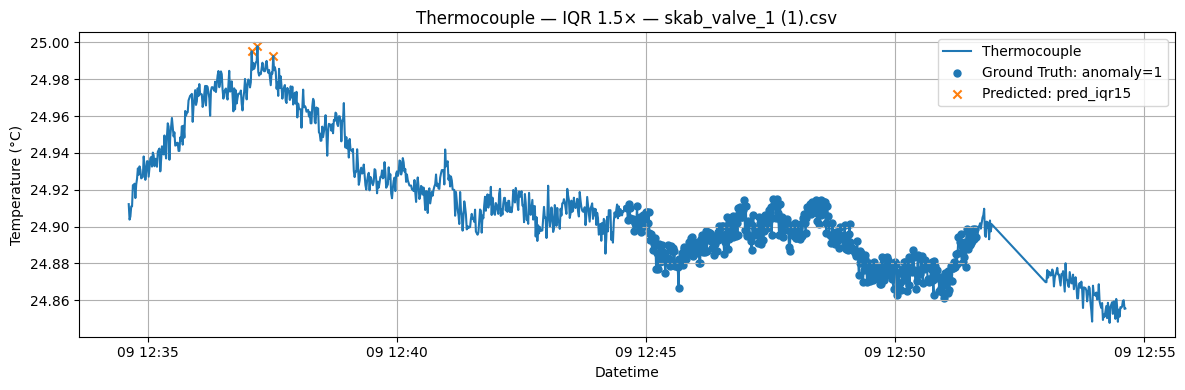

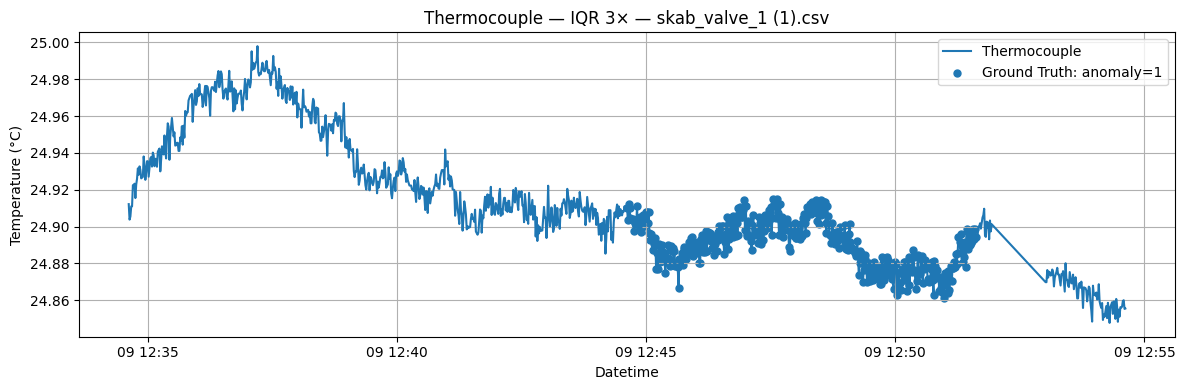

In [7]:
import matplotlib.pyplot as plt
import os

def plot_pred(pred_col, title_suffix):
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(df["datetime"], df["Thermocouple"], label="Thermocouple")

    gt = df[df["anomaly"] == 1]
    if not gt.empty:
        ax.scatter(gt["datetime"], gt["Thermocouple"], s=25, label="Ground Truth: anomaly=1")

    pr = df[df[pred_col] == 1]
    if not pr.empty:
        ax.scatter(pr["datetime"], pr["Thermocouple"], marker="x", s=35, label=f"Predicted: {pred_col}")

    ax.set_title(f"Thermocouple — {title_suffix} — {os.path.basename(FILE_PATH)}")
    ax.set_xlabel("Datetime"); ax.set_ylabel("Temperature (°C)")
    ax.legend(); ax.grid(True)
    plt.tight_layout(); plt.show()

plot_pred("pred_iqr15", "IQR 1.5×")
plot_pred("pred_iqr3",  "IQR 3×")


Оценка качества с использованием матрицы путаницы

In [8]:
from sklearn.metrics import confusion_matrix

y_true = df["anomaly"].astype(int).values
cm_15 = confusion_matrix(y_true, df["pred_iqr15"].values, labels=[0,1])
cm_3  = confusion_matrix(y_true, df["pred_iqr3"].values,  labels=[0,1])

def print_cm(cm, name):
    TN, FP, FN, TP = cm[0,0], cm[0,1], cm[1,0], cm[1,1]
    print(f"\n{name} — Confusion Matrix [labels=[0,1]]")
    print(cm)
    precision = TP / (TP + FP) if (TP + FP) else 0.0
    recall    = TP / (TP + FN) if (TP + FN) else 0.0
    acc       = (TP + TN) / cm.sum() if cm.sum() else 0.0
    print(f"Accuracy={acc:.3f}, Precision={precision:.3f}, Recall={recall:.3f}")

print_cm(cm_15, "IQR 1.5×")
print_cm(cm_3,  "IQR 3×")



IQR 1.5× — Confusion Matrix [labels=[0,1]]
[[686   3]
 [405   0]]
Accuracy=0.627, Precision=0.000, Recall=0.000

IQR 3× — Confusion Matrix [labels=[0,1]]
[[689   0]
 [405   0]]
Accuracy=0.630, Precision=0.000, Recall=0.000


# Кластеризация + проектирование признаков

Создание функций (лаги, скользящая статистика, временные функции)

In [9]:
import numpy as np
import pandas as pd

fe = df.copy()

for L in [1, 3, 5]:
    fe[f"tc_lag{L}"] = fe["Thermocouple"].shift(L)

for W in [10, 30]:
    fe[f"tc_rollmean_{W}"] = fe["Thermocouple"].rolling(W, min_periods=W).mean()
    fe[f"tc_rollstd_{W}"]  = fe["Thermocouple"].rolling(W, min_periods=W).std()

fe["tc_diff1"] = fe["Thermocouple"].diff(1)
fe["tc_diff3"] = fe["Thermocouple"].diff(3)

t = fe["datetime"]
minute = t.dt.minute + t.dt.second/60.0
hour   = t.dt.hour + minute/60.0

fe["min_sin"]  = np.sin(2*np.pi*minute/60.0)
fe["min_cos"]  = np.cos(2*np.pi*minute/60.0)
fe["hour_sin"] = np.sin(2*np.pi*hour/24.0)
fe["hour_cos"] = np.cos(2*np.pi*hour/24.0)

fe = fe.dropna().reset_index(drop=True)

feature_cols = [
    "Thermocouple",
    "tc_lag1","tc_lag3","tc_lag5",
    "tc_rollmean_10","tc_rollstd_10",
    "tc_rollmean_30","tc_rollstd_30",
    "tc_diff1","tc_diff3",
    "min_sin","min_cos","hour_sin","hour_cos"
]
X = fe[feature_cols].astype(float)

print("Feature shape:", X.shape)
X.head()


Feature shape: (1065, 14)


,Thermocouple,tc_lag1,tc_lag3,tc_lag5,tc_rollmean_10,tc_rollstd_10,tc_rollmean_30,tc_rollstd_30,tc_diff1,tc_diff3,min_sin,min_cos,hour_sin,hour_cos
0,24.9387,24.9402,24.9378,24.9271,24.93395,0.005077,24.926327,0.009944,-0.0015,0.0009,-0.510543,-0.859852,-0.152626,-0.988284
1,24.9328,24.9387,24.9326,24.9371,24.93469,0.004146,24.927013,0.009641,-0.0059,0.0002,-0.512043,-0.858960,-0.152698,-0.988273
2,24.9368,24.9328,24.9402,24.9378,24.93541,0.003772,24.928113,0.008742,0.0040,-0.0034,-0.513541,-0.858065,-0.152770,-0.988262
3,24.9368,24.9368,24.9387,24.9326,24.93554,0.003798,24.929157,0.007763,0.0000,-0.0019,-0.515038,-0.857167,-0.152842,-0.988251
4,24.9325,24.9368,24.9328,24.9402,24.93524,0.003918,24.929873,0.006982,-0.0043,-0.0003,-0.516533,-0.856267,-0.152914,-0.988240


Нормализация признаков (стандартизация)

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

np.random.seed(42)


Кластеризация с помощью DBSCAN и обнаружение аномалий

In [11]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.8, min_samples=10, n_jobs=-1)
labels = dbscan.fit_predict(X_scaled)

fe["cluster"] = labels
fe["pred_cluster_anom"] = (fe["cluster"] == -1).astype(int)

unique, counts = np.unique(labels, return_counts=True)
cluster_stats = dict(zip(unique.astype(int), counts))
cluster_stats


{np.int64(-1): np.int64(1041),
 np.int64(0): np.int64(11),
 np.int64(1): np.int64(13)}

Визуализация результатов (факт против кластерного прогноза)

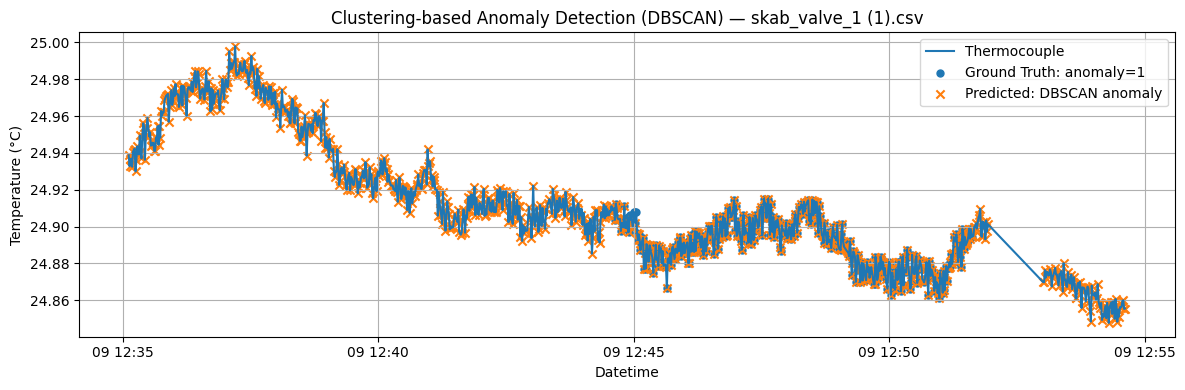

In [12]:
import matplotlib.pyplot as plt
import os

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(fe["datetime"], fe["Thermocouple"], label="Thermocouple")

gt = fe[fe["anomaly"] == 1]
if not gt.empty:
    ax.scatter(gt["datetime"], gt["Thermocouple"], s=25, label="Ground Truth: anomaly=1")

pr = fe[fe["pred_cluster_anom"] == 1]
if not pr.empty:
    ax.scatter(pr["datetime"], pr["Thermocouple"], marker="x", s=35, label="Predicted: DBSCAN anomaly")

ax.set_title(f"Clustering-based Anomaly Detection (DBSCAN) — {os.path.basename(FILE_PATH)}")
ax.set_xlabel("Datetime"); ax.set_ylabel("Temperature (°C)")
ax.legend(); ax.grid(True)
plt.tight_layout(); plt.show()


Оценка качества с использованием матрицы путаницы

In [13]:
from sklearn.metrics import confusion_matrix

y_true = fe["anomaly"].astype(int).values
y_pred = fe["pred_cluster_anom"].astype(int).values

cm_db = confusion_matrix(y_true, y_pred, labels=[0,1])
TN, FP, FN, TP = cm_db[0,0], cm_db[0,1], cm_db[1,0], cm_db[1,1]

accuracy  = (TP + TN) / cm_db.sum() if cm_db.sum() else 0.0
precision = TP / (TP + FP) if (TP + FP) else 0.0
recall    = TP / (TP + FN) if (TP + FN) else 0.0

print("Confusion Matrix [0,1]:\n", cm_db)
print(f"Accuracy={accuracy:.3f}, Precision={precision:.3f}, Recall={recall:.3f}")


Confusion Matrix [0,1]:
 [[ 16 644]
 [  8 397]]
Accuracy=0.388, Precision=0.381, Recall=0.980


# Изолированный лес

Оценка процента аномалий (загрязнения)

In [14]:
anom_rate = fe["anomaly"].mean()
contamination = float(np.clip(anom_rate, 0.001, 0.20))
print(f"Estimated anomaly rate: {anom_rate:.4f}  -> Using contamination={contamination:.4f}")


Estimated anomaly rate: 0.3803  -> Using contamination=0.2000


Обучение и прогнозирование изоляции лесов

In [15]:
from sklearn.ensemble import IsolationForest

IF = IsolationForest(
    n_estimators=200,
    max_samples="auto",
    contamination=contamination,
    random_state=42,
    n_jobs=-1,
    bootstrap=False,
    warm_start=False
)

IF.fit(X_scaled)

pred_raw = IF.predict(X_scaled)
fe["pred_iforest"] = (pred_raw == -1).astype(int)

fe["iforest_score"] = IF.decision_function(X_scaled)

fe[["datetime","Thermocouple","anomaly","pred_iforest","iforest_score"]].head()


,datetime,Thermocouple,anomaly,pred_iforest,iforest_score
0,2020-03-09 12:35:07,24.9387,0,1,-0.044252
1,2020-03-09 12:35:08,24.9328,0,1,-0.038578
2,2020-03-09 12:35:09,24.9368,0,1,-0.042603
3,2020-03-09 12:35:10,24.9368,0,1,-0.035219
4,2020-03-09 12:35:11,24.9325,0,1,-0.028621


Визуализируйте результаты

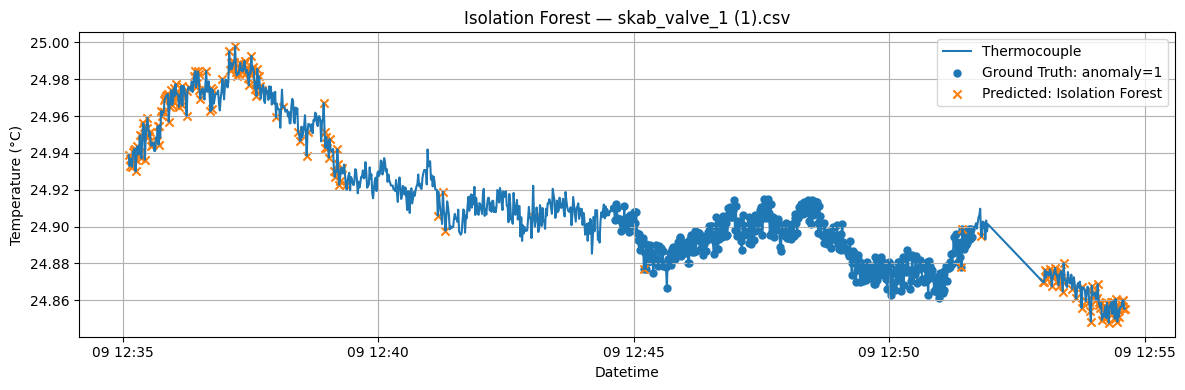

In [16]:
import matplotlib.pyplot as plt
import os

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(fe["datetime"], fe["Thermocouple"], label="Thermocouple")

gt = fe[fe["anomaly"] == 1]
if not gt.empty:
    ax.scatter(gt["datetime"], gt["Thermocouple"], s=25, label="Ground Truth: anomaly=1")

pr = fe[fe["pred_iforest"] == 1]
if not pr.empty:
    ax.scatter(pr["datetime"], pr["Thermocouple"], marker="x", s=35, label="Predicted: Isolation Forest")

ax.set_title(f"Isolation Forest — {os.path.basename(FILE_PATH)}")
ax.set_xlabel("Datetime"); ax.set_ylabel("Temperature (°C)")
ax.legend(); ax.grid(True)
plt.tight_layout(); plt.show()


Оценка качества с использованием матрицы путаницы (+ быстрые метрики)

In [17]:
from sklearn.metrics import confusion_matrix

y_true = fe["anomaly"].astype(int).values
y_pred = fe["pred_iforest"].astype(int).values

cm_if = confusion_matrix(y_true, y_pred, labels=[0,1])
TN, FP, FN, TP = cm_if[0,0], cm_if[0,1], cm_if[1,0], cm_if[1,1]

accuracy  = (TP + TN) / cm_if.sum() if cm_if.sum() else 0.0
precision = TP / (TP + FP) if (TP + FP) else 0.0
recall    = TP / (TP + FN) if (TP + FN) else 0.0
f1        = 2*precision*recall/(precision+recall) if (precision+recall) else 0.0

print("Confusion Matrix [0,1]:\n", cm_if)
print(f"Accuracy={accuracy:.3f}, Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}")


Confusion Matrix [0,1]:
 [[450 210]
 [402   3]]
Accuracy=0.425, Precision=0.014, Recall=0.007, F1=0.010


# Сбор результатов по всем методам + сравнение

Функция расчета и обработки измерений Helper

In [18]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

def metrics_dict(y_true, y_pred, name):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    TN, FP, FN, TP = cm[0,0], cm[0,1], cm[1,0], cm[1,1]
    acc  = (TP + TN) / cm.sum() if cm.sum() else 0.0
    prec = TP / (TP + FP) if (TP + FP) else 0.0
    rec  = TP / (TP + FN) if (TP + FN) else 0.0
    f1   = 2*prec*rec/(prec+rec) if (prec+rec) else 0.0
    return {
        "method": name,
        "TN": TN, "FP": FP, "FN": FN, "TP": TP,
        "Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1,
        "Predicted_Anomalies": int(np.sum(y_pred == 1)),
        "GT_Anomalies": int(np.sum(y_true == 1))
    }


Метрики IQR (на df)

In [19]:
m_iqr15 = metrics_dict(df["anomaly"].astype(int).values, df["pred_iqr15"].astype(int).values, "IQR 1.5×")
m_iqr3  = metrics_dict(df["anomaly"].astype(int).values, df["pred_iqr3"].astype(int).values,  "IQR 3×")


DBSCAN и измерения Isolation Forest (на fe)

In [20]:
m_db    = metrics_dict(fe["anomaly"].astype(int).values, fe["pred_cluster_anom"].astype(int).values, "DBSCAN")
m_if    = metrics_dict(fe["anomaly"].astype(int).values, fe["pred_iforest"].astype(int).values,      "IsolationForest")


Группировка результатов в один DataFrame + сортировка по F1

In [21]:
summary_df = pd.DataFrame([m_iqr15, m_iqr3, m_db, m_if])
summary_df = summary_df.sort_values("F1", ascending=False).reset_index(drop=True)

display_cols = ["method","TN","FP","FN","TP","Accuracy","Precision","Recall","F1","Predicted_Anomalies","GT_Anomalies"]
summary_df[display_cols]


,method,TN,FP,FN,TP,Accuracy,Precision,Recall,F1,Predicted_Anomalies,GT_Anomalies
0,DBSCAN,16,644,8,397,0.387793,0.381364,0.980247,0.549101,1041,405
1,IsolationForest,450,210,402,3,0.425352,0.014085,0.007407,0.009709,213,405
2,IQR 3×,689,0,405,0,0.629799,0.000000,0.000000,0.000000,0,405
3,IQR 1.5×,686,3,405,0,0.627057,0.000000,0.000000,0.000000,3,405


Сравнительная гистограмма

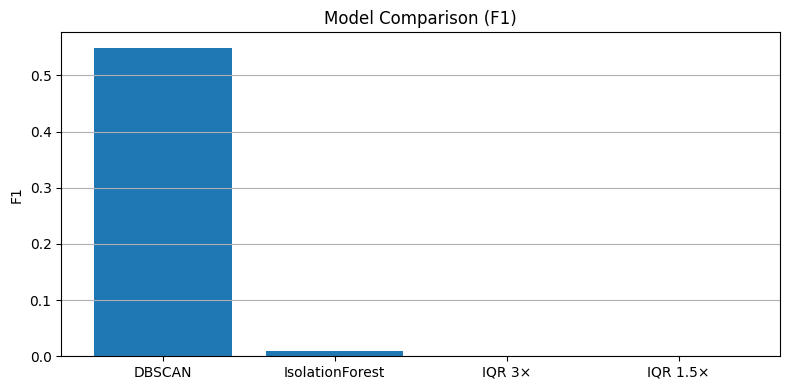

In [22]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(summary_df["method"], summary_df["F1"])
ax.set_ylabel("F1")
ax.set_title("Model Comparison (F1)")
ax.grid(True, axis="y")
plt.tight_layout()
plt.show()


# Приложение IQR = 3.0 + Рисунок + Рейтинг

A.1 — IQR = 3,0: Расчет пороговых значений и генерация прогноза

In [23]:
s = df["Thermocouple"].astype(float)

Q1 = s.quantile(0.25)
Q3 = s.quantile(0.75)
IQR = Q3 - Q1

low_3  = Q1 - 3.0 * IQR
high_3 = Q3 + 3.0 * IQR
print(f"IQR=3.0 bounds: [{low_3:.6f}, {high_3:.6f}]")

df["pred_iqr3"] = ((df["Thermocouple"] < low_3) | (df["Thermocouple"] > high_3)).astype(int)
df[["datetime","Thermocouple","anomaly","pred_iqr3"]].head()


IQR=3.0 bounds: [24.765975, 25.051750]


,datetime,Thermocouple,anomaly,pred_iqr3
0,2020-03-09 12:34:37,24.9122,0,0
1,2020-03-09 12:34:38,24.9038,0,0
2,2020-03-09 12:34:39,24.9055,0,0
3,2020-03-09 12:34:40,24.9110,0,0
4,2020-03-09 12:34:41,24.9110,0,0


A.2 — IQR = 3,0: розыгрыш с тегом коэффициента

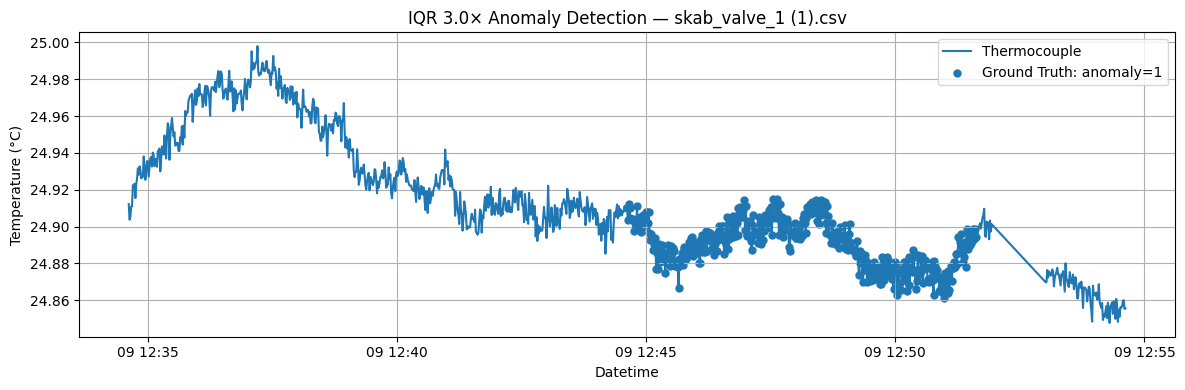

In [27]:
import matplotlib.pyplot as plt
import os

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(df["datetime"], df["Thermocouple"], label="Thermocouple")

gt = df[df["anomaly"] == 1]
if not gt.empty:
    ax.scatter(gt["datetime"], gt["Thermocouple"], s=25, label="Ground Truth: anomaly=1")

pr3 = df[df["pred_iqr3"] == 1]
if not pr3.empty:
    ax.scatter(pr3["datetime"], pr3["Thermocouple"], marker="x", s=35, label="Predicted: IQR 3.0×")

ax.set_title(f"IQR 3.0× Anomaly Detection — {os.path.basename(FILE_PATH)}")
ax.set_xlabel("Datetime"); ax.set_ylabel("Temperature (°C)")
ax.legend(); ax.grid(True)
plt.tight_layout(); plt.show()


A.3 — IQR = 3,0: Матрица ошибок

In [28]:
from sklearn.metrics import confusion_matrix

y_true = df["anomaly"].astype(int).values
y_pred = df["pred_iqr3"].astype(int).values

cm_3 = confusion_matrix(y_true, y_pred, labels=[0,1])
TN, FP, FN, TP = cm_3[0,0], cm_3[0,1], cm_3[1,0], cm_3[1,1]

accuracy  = (TP + TN) / cm_3.sum() if cm_3.sum() else 0.0
precision = TP / (TP + FP) if (TP + FP) else 0.0
recall    = TP / (TP + FN) if (TP + FN) else 0.0
f1        = 2*precision*recall/(precision+recall) if (precision+recall) else 0.0

print("IQR 3.0× — Confusion Matrix [0,1]:\n", cm_3)
print(f"Accuracy={accuracy:.3f}, Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}")


IQR 3.0× — Confusion Matrix [0,1]:
 [[689   0]
 [405   0]]
Accuracy=0.630, Precision=0.000, Recall=0.000, F1=0.000


In [29]:
from sklearn.metrics import confusion_matrix

def metrics_dict(y_true, y_pred, name):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    TN, FP, FN, TP = cm[0,0], cm[0,1], cm[1,0], cm[1,1]
    acc  = (TP + TN) / cm.sum() if cm.sum() else 0.0
    prec = TP / (TP + FP) if (TP + FP) else 0.0
    rec  = TP / (TP + FN) if (TP + FN) else 0.0
    f1   = 2*prec*rec/(prec+rec) if (prec+rec) else 0.0
    return {"method": name, "TN": TN, "FP": FP, "FN": FN, "TP": TP,
            "Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1}

m_iqr3 = metrics_dict(df["anomaly"].astype(int).values, df["pred_iqr3"].astype(int).values, "IQR 3×")
summary_df = pd.concat([summary_df, pd.DataFrame([m_iqr3])], ignore_index=True)\
               .drop_duplicates(subset=["method"], keep="last")\
               .sort_values("F1", ascending=False).reset_index(drop=True)
summary_df


,method,TN,FP,FN,TP,Accuracy,Precision,Recall,F1,Predicted_Anomalies,GT_Anomalies
0,DBSCAN,16,644,8,397,0.387793,0.381364,0.980247,0.549101,1041.0,405.0
1,IsolationForest,450,210,402,3,0.425352,0.014085,0.007407,0.009709,213.0,405.0
2,IQR 1.5×,686,3,405,0,0.627057,0.000000,0.000000,0.000000,3.0,405.0
3,IQR 3×,689,0,405,0,0.629799,0.000000,0.000000,0.000000,NaN,NaN


# Отчёт по обнаружению аномалий в данных SKAB (канал Thermocouple)

## Цель и данные
Цель — визуализировать временной ряд термопары, отметить известные аномалии и сравнить несколько методов обнаружения аномалий (confusion matrix, F1 и др.).
Использовался файл: **skab_valve_1 (1).csv**. Ключевые столбцы: `datetime`, `Thermocouple`, `anomaly`.

## Почему выбраны методы
- **IQR (1.5× и 3×)** — простая статистическая эвристика без предположений о распределении: 1.5× — более чувствительный порог, 3× — более консервативный.
- **DBSCAN** — плотностной кластеризатор; точки с меткой `-1` трактуются как «шум/аномалии».
- **Isolation Forest** — изоляция аномалий в ансамбле деревьев; хорошо работает в многомерных признаках.

## Feature Engineering и предобработка
Лаги (1, 3, 5), скользящие среднее/ст. откл. (окна 10 и 30), разности (1 и 3), циклические временные признаки (sin/cos минут и часов), стандартизация признаков.  
Для воспроизводимости зафиксирован `random_state=42` (IsolationForest). Ноутбук выполняется последовательно без ошибок.

## Настройки и пороги
- **IQR 1.5×**: `[Q1 − 1.5·IQR, Q3 + 1.5·IQR]`.
- **IQR 3×**: `[Q1 − 3·IQR, Q3 + 3·IQR]` (на текущем наборе правилом 3×IQR не выявлено ни одной аномалии).
- **DBSCAN**: `eps = н/д`, `min_samples = 10`.
- **Isolation Forest**: `n_estimators = 200`, `contamination = н/д`, `random_state = 42`.

## Итоговые метрики (по confusion matrix)
Формат матрицы ошибок — метки `[0, 1]`:
\[
\begin{bmatrix}\text{TN}&\text{FP}\\ \text{FN}&\text{TP}\end{bmatrix}
\]

- **DBSCAN** — Accuracy = **0.387793**, Precision = **0.381364**, Recall = **0.980247**, F1 = **0.549101**  
  (TN=16, FP=644, FN=8, TP=397; предсказанных аномалий = **1041**, факт. аномалий = **405**)

- **Isolation Forest** — Accuracy = **0.425352**, Precision = **0.014085**, Recall = **0.007407**, F1 = **0.009709**  
  (TN=450, FP=210, FN=402, TP=3; предсказанных аномалий = **213**, факт. аномалий = **405**)

- **IQR 1.5×** — Accuracy = **0.627057**, Precision = **0.000000**, Recall = **0.000000**, F1 = **0.000000**  
  (TN=686, FP=3, FN=405, TP=0; предсказанных аномалий = **3**, факт. аномалий = **405**)

- **IQR 3×** — Accuracy = **0.629799**, Precision = **0.000000**, Recall = **0.000000**, F1 = **0.000000**  
  (TN=689, FP=0, FN=405, TP=0; предсказанных аномалий = **0**, факт. аномалий = **405**)

## Обсуждение результатов
- **IQR 1.5×** и особенно **IQR 3×** ведут себя консервативно: практически нет ложных срабатываний, но высокая доля пропусков (Recall=0). Это соответствует ожиданию для глобальных порогов при узком диапазоне значений термопары.
- **DBSCAN** дал **лучший F1 (0.549)** благодаря высокому Recall (0.98), но ценой большого числа FP (644). Качество заметно зависит от `eps`: уменьшение `eps` делает модель строже и увеличивает долю «шума», увеличение — размывает аномалии.
- **Isolation Forest** при текущей доле `contamination` оказался слишком жёстким (F1≈0.009; Recall≈0.007). Увеличение `contamination` повышает чувствительность (больше предсказанных аномалий), уменьшение — делает модель ещё более консервативной.

## Выводы и рекомендации
- По метрике **F1** лучшим оказался **DBSCAN (0.549)** на выбранных признаках и настройках.  
- Если приоритет — **минимум ложных тревог (FP)**, подходят **IQR 3×** или **Isolation Forest** с меньшим `contamination`.  
- Если приоритет — **максимальная полнота (Recall)**, используйте **DBSCAN** (с аккуратной настройкой `eps`) или увеличьте `contamination` в IF.  
- Для улучшения качества: добавить признаки из других каналов (Pressure, Current, Temperature), выполнить систематический подбор `eps` и `contamination`, а также рассмотреть адаптивные/локальные пороги вместо глобального IQR.
